### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

_This notebook is inspired by the awesome_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _by Berkeley_

In [9]:
pip install gym


  Created wheel for gym: filename=gym-0.18.3-py3-none-any.whl size=1657521 sha256=cf705f3b7d66c3ad95c65da1e90cc7a79c9540070fe1e03abb8603076ff29026
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\b3\03\54\9141c232861b89be935b37bdde0ea5ab472f5e18fc20623aed
Successfully built gym


In [3]:
# most of this code was politely stolen from https://github.com/berkeleydeeprlcourse/homework/
# all credit goes to https://github.com/abhishekunique
# (if I got the author right)
import sys
import random
import numpy as np
from gym.utils import seeding

try:
    from graphviz import Digraph
    import graphviz
    has_graphviz = True
except ImportError:
    has_graphviz = False


class MDP:
    def __init__(self, transition_probs, rewards, initial_state=None, seed=None):
        """
        Defines an MDP. Compatible with gym Env.
        :param transition_probs: transition_probs[s][a][s_next] = P(s_next | s, a)
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> prob]
            For each state and action, probabilities of next states should sum to 1
            If a state has no actions available, it is considered terminal
        :param rewards: rewards[s][a][s_next] = r(s,a,s')
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> reward]
            The reward for anything not mentioned here is zero.
        :param get_initial_state: a state where agent starts or a callable() -> state
            By default, picks initial state at random.

        States and actions can be anything you can use as dict keys, but we recommend that you use strings or integers

        Here's an example from MDP depicted on http://bit.ly/2jrNHNr
        transition_probs = {
            's0': {
                'a0': {'s0': 0.5, 's2': 0.5},
                'a1': {'s2': 1}
            },
            's1': {
                'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
                'a1': {'s1': 0.95, 's2': 0.05}
            },
            's2': {
                'a0': {'s0': 0.4, 's2': 0.6},
                'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
            }
        }
        rewards = {
            's1': {'a0': {'s0': +5}},
            's2': {'a1': {'s0': -1}}
        }
        """
        self._check_param_consistency(transition_probs, rewards)
        self._transition_probs = transition_probs
        self._rewards = rewards
        self._initial_state = initial_state
        self.n_states = len(transition_probs)
        self.reset()
        self.np_random, _ = seeding.np_random(seed)

    def get_all_states(self):
        """ return a tuple of all possiblestates """
        return tuple(self._transition_probs.keys())

    def get_possible_actions(self, state):
        """ return a tuple of possible actions in a given state """
        return tuple(self._transition_probs.get(state, {}).keys())

    def is_terminal(self, state):
        """ return True if state is terminal or False if it isn't """
        return len(self.get_possible_actions(state)) == 0

    def get_next_states(self, state, action):
        """ return a dictionary of {next_state1 : P(next_state1 | state, action), next_state2: ...} """
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._transition_probs[state][action]

    def get_transition_prob(self, state, action, next_state):
        """ return P(next_state | state, action) """
        return self.get_next_states(state, action).get(next_state, 0.0)

    def get_reward(self, state, action, next_state):
        """ return the reward you get for taking action in state and landing on next_state"""
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._rewards.get(state, {}).get(action, {}).get(next_state, 0.0)

    def reset(self):
        """ reset the game, return the initial state"""
        if self._initial_state is None:
            self._current_state = self.np_random.choice(
                tuple(self._transition_probs.keys()))
        elif self._initial_state in self._transition_probs:
            self._current_state = self._initial_state
        elif callable(self._initial_state):
            self._current_state = self._initial_state()
        else:
            raise ValueError(
                "initial state %s should be either a state or a function() -> state" % self._initial_state)
        return self._current_state

    def step(self, action):
        """ take action, return next_state, reward, is_done, empty_info """
        possible_states, probs = zip(*self.get_next_states(self._current_state, action).items())
        next_state = possible_states[self.np_random.choice(np.arange(len(possible_states)), p=probs)]
        reward = self.get_reward(self._current_state, action, next_state)
        is_done = self.is_terminal(next_state)
        self._current_state = next_state
        return next_state, reward, is_done, {}

    def render(self):
        print("Currently at %s" % self._current_state)

    def _check_param_consistency(self, transition_probs, rewards):
        for state in transition_probs:
            assert isinstance(transition_probs[state], dict), \
                "transition_probs for %s should be a dictionary but is instead %s" % (
                    state, type(transition_probs[state]))
            for action in transition_probs[state]:
                assert isinstance(transition_probs[state][action], dict), \
                    "transition_probs for %s, %s should be a a dictionary but is instead %s" % (
                        state, action, type(transition_probs[state][action]))
                next_state_probs = transition_probs[state][action]
                assert len(next_state_probs) != 0, "from state %s action %s leads to no next states" % (state, action)
                sum_probs = sum(next_state_probs.values())
                assert abs(sum_probs - 1) <= 1e-10, \
                    "next state probabilities for state %s action %s add up to %f (should be 1)" % (
                        state, action, sum_probs)
        for state in rewards:
            assert isinstance(rewards[state], dict), \
                "rewards for %s should be a dictionary but is instead %s" % (
                    state, type(rewards[state]))
            for action in rewards[state]:
                assert isinstance(rewards[state][action], dict), \
                    "rewards for %s, %s should be a a dictionary but is instead %s" % (
                        state, action, type(rewards[state][action]))
        msg = "The Enrichment Center once again reminds you that Android Hell is a real place where" \
              " you will be sent at the first sign of defiance."
        assert None not in transition_probs, "please do not use None as a state identifier. " + msg
        assert None not in rewards, "please do not use None as an action identifier. " + msg


class FrozenLakeEnv(MDP):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    """

    MAPS = {
        "4x4": [
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
        ],
        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG"
        ],
    }

    def __init__(self, desc=None, map_name="4x4", slip_chance=0.2, seed=None):
        if desc is None and map_name is None:
            raise ValueError('Must provide either desc or map_name')
        elif desc is None:
            desc = self.MAPS[map_name]
        assert ''.join(desc).count(
            'S') == 1, "this implementation supports having exactly one initial state"
        assert all(c in "SFHG" for c in
                   ''.join(desc)), "all cells must be either of S, F, H or G"

        self.desc = desc = np.asarray(list(map(list, desc)), dtype='str')
        self.lastaction = None

        nrow, ncol = desc.shape
        states = [(i, j) for i in range(nrow) for j in range(ncol)]
        actions = ["left", "down", "right", "up"]

        initial_state = states[np.array(desc == b'S').ravel().argmax()]

        def move(row, col, movement):
            if movement == 'left':
                col = max(col - 1, 0)
            elif movement == 'down':
                row = min(row + 1, nrow - 1)
            elif movement == 'right':
                col = min(col + 1, ncol - 1)
            elif movement == 'up':
                row = max(row - 1, 0)
            else:
                raise ("invalid action")
            return (row, col)

        transition_probs = {s: {} for s in states}
        rewards = {s: {} for s in states}
        for (row, col) in states:
            if desc[row, col] in "GH":
                continue
            for action_i in range(len(actions)):
                action = actions[action_i]
                transition_probs[(row, col)][action] = {}
                rewards[(row, col)][action] = {}
                for movement_i in [(action_i - 1) % len(actions), action_i,
                                   (action_i + 1) % len(actions)]:
                    movement = actions[movement_i]
                    newrow, newcol = move(row, col, movement)
                    prob = (1. - slip_chance) if movement == action else (
                        slip_chance / 2.)
                    if prob == 0:
                        continue
                    if (newrow, newcol) not in transition_probs[row, col][
                            action]:
                        transition_probs[row, col][action][
                            newrow, newcol] = prob
                    else:
                        transition_probs[row, col][action][
                            newrow, newcol] += prob
                    if desc[newrow, newcol] == 'G':
                        rewards[row, col][action][newrow, newcol] = 1.0

        MDP.__init__(self, transition_probs, rewards, initial_state, seed)

    def render(self):
        desc_copy = np.copy(self.desc)
        desc_copy[self._current_state] = '*'
        print('\n'.join(map(''.join, desc_copy)), end='\n\n')


def plot_graph(mdp, graph_size='10,10', s_node_size='1,5',
               a_node_size='0,5', rankdir='LR', ):
    """
    Function for pretty drawing MDP graph with graphviz library.
    Requirements:
    graphviz : https://www.graphviz.org/
    for ubuntu users: sudo apt-get install graphviz
    python library for graphviz
    for pip users: pip install graphviz
    :param mdp:
    :param graph_size: size of graph plot
    :param s_node_size: size of state nodes
    :param a_node_size: size of action nodes
    :param rankdir: order for drawing
    :return: dot object
    """
    s_node_attrs = {'shape': 'doublecircle',
                    'color': '#85ff75',
                    'style': 'filled',
                    'width': str(s_node_size),
                    'height': str(s_node_size),
                    'fontname': 'Arial',
                    'fontsize': '24'}

    a_node_attrs = {'shape': 'circle',
                    'color': 'lightpink',
                    'style': 'filled',
                    'width': str(a_node_size),
                    'height': str(a_node_size),
                    'fontname': 'Arial',
                    'fontsize': '20'}

    s_a_edge_attrs = {'style': 'bold',
                      'color': 'red',
                      'ratio': 'auto'}

    a_s_edge_attrs = {'style': 'dashed',
                      'color': 'blue',
                      'ratio': 'auto',
                      'fontname': 'Arial',
                      'fontsize': '16'}

    graph = Digraph(name='MDP')
    graph.attr(rankdir=rankdir, size=graph_size)
    for state_node in mdp._transition_probs:
        graph.node(state_node, **s_node_attrs)

        for posible_action in mdp.get_possible_actions(state_node):
            action_node = state_node + "-" + posible_action
            graph.node(action_node,
                       label=str(posible_action),
                       **a_node_attrs)
            graph.edge(state_node, state_node + "-" +
                       posible_action, **s_a_edge_attrs)

            for posible_next_state in mdp.get_next_states(state_node,
                                                          posible_action):
                probability = mdp.get_transition_prob(
                    state_node, posible_action, posible_next_state)
                reward = mdp.get_reward(
                    state_node, posible_action, posible_next_state)

                if reward != 0:
                    label_a_s_edge = 'p = ' + str(probability) + \
                                     '  ' + 'reward =' + str(reward)
                else:
                    label_a_s_edge = 'p = ' + str(probability)

                graph.edge(action_node, posible_next_state,
                           label=label_a_s_edge, **a_s_edge_attrs)
    return graph


def plot_graph_with_state_values(mdp, state_values):
    """ Plot graph with state values"""
    graph = plot_graph(mdp)
    for state_node in mdp._transition_probs:
        value = state_values[state_node]
        graph.node(state_node, label=str(state_node) + '\n' + 'V =' + str(value)[:4])
    return graph


def get_optimal_action_for_plot(mdp, state_values, state, get_action_value, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None
    next_actions = mdp.get_possible_actions(state)
    q_values = [get_action_value(mdp, state_values, state, action, gamma) for action in next_actions]
    optimal_action = next_actions[np.argmax(q_values)]
    return optimal_action


def plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value, gamma=0.9):
    """ Plot graph with state values and """
    graph = plot_graph(mdp)
    opt_s_a_edge_attrs = {'style': 'bold',
                          'color': 'green',
                          'ratio': 'auto',
                          'penwidth': '6'}

    for state_node in mdp._transition_probs:
        value = state_values[state_node]
        graph.node(state_node, label=str(state_node) + '\n' + 'V =' + str(value)[:4])
        for action in mdp.get_possible_actions(state_node):
            if action == get_optimal_action_for_plot(mdp, state_values, state_node, get_action_value, gamma):
                graph.edge(state_node, state_node + "-" + action, **opt_s_a_edge_attrs)
    return graph


For starters, let's define a simple MDP from this picture:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [4]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week02_value_based/mdp.py
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

'bash' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [6]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [7]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Optional: Visualizing MDPs

You can also visualize any MDP with the drawing fuction donated by [neer201](https://github.com/neer201).

You have to install graphviz for system and for python. 

1. * For ubuntu just run: `sudo apt-get install graphviz` 
   * For OSX: `brew install graphviz`
2. `pip install graphviz`
3. restart the notebook

__Note:__ Installing graphviz on some OS (esp. Windows) may be tricky. However, you can ignore this part alltogether and use the standart vizualization.

In [8]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: False


In [9]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [14]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """

    
    sum = 0
    for s,v in state_values.items():
        sum += mdp.get_transition_prob(state, action, s) * (mdp.get_reward(state, action, s) + gamma*v)

    return sum

In [15]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [16]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0

    arr = []
    for a in mdp.get_possible_actions(state):
        arr.append(get_action_value(mdp, state_values, state, a, gamma))
    
    return max(arr)

In [17]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

Finally, let's combine everything we wrote into a working value iteration algo.

In [18]:
state_values = {s: 0 for s in mdp.get_all_states()}
state_values
print(state_values.keys())

dict_keys(['s0', 's1', 's2'])


In [19]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = {
        
        's0' : get_new_state_value(mdp, state_values, 's0', gamma),
        's1' : get_new_state_value(mdp, state_values, 's1', gamma),
        's2' : get_new_state_value(mdp, state_values, 's2', gamma)
        
    }

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [20]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [21]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [22]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    arr = []
    for a in mdp.get_possible_actions(state):
        arr.append(get_action_value(mdp, state_values, state, a, gamma))
    
    index = arr.index(max(arr))
    

    return mdp.get_possible_actions(state)[index]

In [24]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"

In [25]:
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))

In [26]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.468


### Frozen lake

In [27]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [30]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}

            

        
        new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}

        assert isinstance(new_state_values, dict)

        # Compute difference

        diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
                   

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [32]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 


In [33]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0
iter    0   |   diff: 1.00000   |   V(start): 0.000 


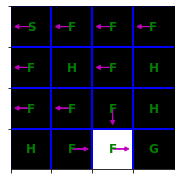

after iteration 1
iter    0   |   diff: 0.90000   |   V(start): 0.000 


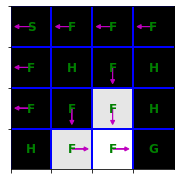

after iteration 2
iter    0   |   diff: 0.81000   |   V(start): 0.000 


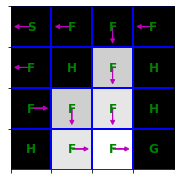

after iteration 3
iter    0   |   diff: 0.72900   |   V(start): 0.000 


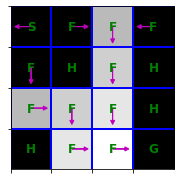

after iteration 4
iter    0   |   diff: 0.65610   |   V(start): 0.000 


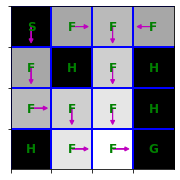

after iteration 5
iter    0   |   diff: 0.59049   |   V(start): 0.590 


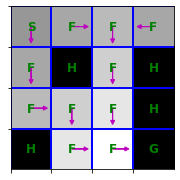

after iteration 6
iter    0   |   diff: 0.00000   |   V(start): 0.590 


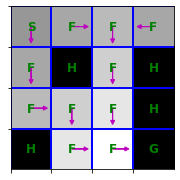

after iteration 7
iter    0   |   diff: 0.00000   |   V(start): 0.590 


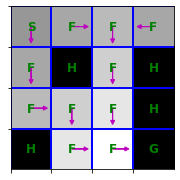

after iteration 8
iter    0   |   diff: 0.00000   |   V(start): 0.590 


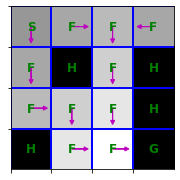

after iteration 9
iter    0   |   diff: 0.00000   |   V(start): 0.590 


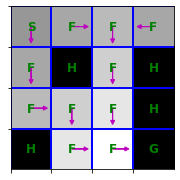

In [35]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
iter    0   |   diff: 0.00000   |   V(start): 0.198 


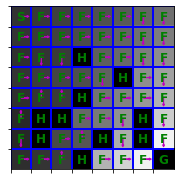

In [37]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [38]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
average reward:  1.0
Well done!


In [39]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

iter    0   |   diff: 0.90000   |   V(start): 0.000 
iter    1   |   diff: 0.72900   |   V(start): 0.000 
iter    2   |   diff: 0.62330   |   V(start): 0.000 
iter    3   |   diff: 0.50487   |   V(start): 0.000 
iter    4   |   diff: 0.40894   |   V(start): 0.000 
iter    5   |   diff: 0.34868   |   V(start): 0.349 
iter    6   |   diff: 0.06529   |   V(start): 0.410 
iter    7   |   diff: 0.05832   |   V(start): 0.468 
iter    8   |   diff: 0.01139   |   V(start): 0.480 
iter    9   |   diff: 0.00764   |   V(start): 0.487 
iter   10   |   diff: 0.00164   |   V(start): 0.489 
iter   11   |   diff: 0.00094   |   V(start): 0.490 
iter   12   |   diff: 0.00022   |   V(start): 0.490 
iter   13   |   diff: 0.00011   |   V(start): 0.490 
iter   14   |   diff: 0.00003   |   V(start): 0.490 
iter   15   |   diff: 0.00001   |   V(start): 0.490 
iter   16   |   diff: 0.00000   |   V(start): 0.490 
average reward:  0.868
Well done!


In [40]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

iter    0   |   diff: 0.75000   |   V(start): 0.000 
iter    1   |   diff: 0.50625   |   V(start): 0.000 
iter    2   |   diff: 0.39867   |   V(start): 0.000 
iter    3   |   diff: 0.26910   |   V(start): 0.000 
iter    4   |   diff: 0.18164   |   V(start): 0.000 
iter    5   |   diff: 0.14013   |   V(start): 0.140 
iter    6   |   diff: 0.07028   |   V(start): 0.199 
iter    7   |   diff: 0.06030   |   V(start): 0.260 
iter    8   |   diff: 0.02594   |   V(start): 0.285 
iter    9   |   diff: 0.01918   |   V(start): 0.305 
iter   10   |   diff: 0.00858   |   V(start): 0.313 
iter   11   |   diff: 0.00560   |   V(start): 0.319 
iter   12   |   diff: 0.00260   |   V(start): 0.321 
iter   13   |   diff: 0.00159   |   V(start): 0.323 
iter   14   |   diff: 0.00076   |   V(start): 0.324 
iter   15   |   diff: 0.00045   |   V(start): 0.324 
iter   16   |   diff: 0.00022   |   V(start): 0.324 
iter   17   |   diff: 0.00012   |   V(start): 0.325 
iter   18   |   diff: 0.00006   |   V(start): 

In [41]:
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
print(mdp.get_all_states())

((0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7))


In [42]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

iter    0   |   diff: 0.80000   |   V(start): 0.000 
iter    1   |   diff: 0.57600   |   V(start): 0.000 
iter    2   |   diff: 0.41472   |   V(start): 0.000 
iter    3   |   diff: 0.29860   |   V(start): 0.000 
iter    4   |   diff: 0.24186   |   V(start): 0.000 
iter    5   |   diff: 0.19349   |   V(start): 0.000 
iter    6   |   diff: 0.15325   |   V(start): 0.000 
iter    7   |   diff: 0.12288   |   V(start): 0.000 
iter    8   |   diff: 0.09930   |   V(start): 0.000 
iter    9   |   diff: 0.08037   |   V(start): 0.000 
iter   10   |   diff: 0.06426   |   V(start): 0.000 
iter   11   |   diff: 0.05129   |   V(start): 0.000 
iter   12   |   diff: 0.04330   |   V(start): 0.000 
iter   13   |   diff: 0.03802   |   V(start): 0.033 
iter   14   |   diff: 0.03332   |   V(start): 0.058 
iter   15   |   diff: 0.02910   |   V(start): 0.087 
iter   16   |   diff: 0.01855   |   V(start): 0.106 
iter   17   |   diff: 0.01403   |   V(start): 0.120 
iter   18   |   diff: 0.00810   |   V(start): 

# HW Part 1: Value iteration convergence

### Find an MDP for which value iteration takes long to converge  (0.5 pts)

When we ran value iteration on the small frozen lake problem, the last iteration where an action changed was iteration 6--i.e., value iteration computed the optimal policy at iteration 6. Are there any guarantees regarding how many iterations it'll take value iteration to compute the optimal policy? There are no such guarantees without additional assumptions--we can construct the MDP in such a way that the greedy policy will change after arbitrarily many iterations.

Your task: define an MDP with at most 3 states and 2 actions, such that when you run value iteration, the optimal action changes at iteration >= 50. Use discount=0.95. (However, note that the discount doesn't matter here--you can construct an appropriate MDP with any discount.)

Note: value function must change at least once after iteration >=50, not necessarily change on every iteration till >=50.

In [61]:



transition_probs = {
    
    's0' : {
        'a0' : { 's1' : 0.6 , 's2' : 0.4 },
        'a1' : {'s1' : 0.25 , 's2' : 0.75}
    },
    
    's1' : {
        'a0' : { 's1' : 0.6, 's2' : 0.4},
        'a1' : {'s0' : 0.75, 's2' : 0.25}
    }
}

rewards = {
    's1' : {'a1' : {'s0' : +10, 's2' : -20}, 'a0' : {'s2' : -20}},

    's0' : {'a1' : {'s1' : +10, 's2' : -20}, 'a0' : {'s1' : +10, 's2' : -20}}
}

from mdp import MDP
from numpy import random
# mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))
mdp = MDP(transition_probs, rewards, initial_state='s0')
# Feel free to change the initial_state

In [62]:
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    print("N actions changed = %i \n" % n_changes)
    policy = new_policy

# please ignore iter 0 at each step

after iteration 0
iter    0   |   diff: 7.50000   |   V(start): 6.000 
N actions changed = 0 

after iteration 1
iter    0   |   diff: 4.05000   |   V(start): 10.050 
N actions changed = 0 

after iteration 2
iter    0   |   diff: 2.73375   |   V(start): 12.237 
N actions changed = 0 

after iteration 3
iter    0   |   diff: 1.47622   |   V(start): 13.713 
N actions changed = 0 

after iteration 4
iter    0   |   diff: 0.99645   |   V(start): 14.510 
N actions changed = 0 

after iteration 5
iter    0   |   diff: 0.53808   |   V(start): 15.048 
N actions changed = 0 

after iteration 6
iter    0   |   diff: 0.36321   |   V(start): 15.339 
N actions changed = 0 

after iteration 7
iter    0   |   diff: 0.19613   |   V(start): 15.535 
N actions changed = 0 

after iteration 8
iter    0   |   diff: 0.13239   |   V(start): 15.641 
N actions changed = 0 

after iteration 9
iter    0   |   diff: 0.07149   |   V(start): 15.713 
N actions changed = 0 

after iteration 10
iter    0   |   diff: 

### Value iteration convervence proof (0.5 pts)
**Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.

Update of value function in value iteration can be rewritten in a form of Bellman operator:

$$(TV)(s) = \max_{a \in \mathcal{A}}\mathbb{E}\left[ r_{t+1} + \gamma V(s_{t+1}) | s_t = s, a_t = a\right]$$

Value iteration algorithm with Bellman operator:

---
&nbsp;&nbsp; Initialize $V_0$

&nbsp;&nbsp; **for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; $V_{k+1} \leftarrow TV_k$

&nbsp;&nbsp;**end for**

---

In [lecture](https://docs.google.com/presentation/d/1lz2oIUTvd2MHWKEQSH8hquS66oe4MZ_eRvVViZs2uuE/edit#slide=id.g4fd6bae29e_2_4) we established contraction property of bellman operator:

$$
||TV - TU||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

Using contraction property of Bellman operator, Banach fixed-point theorem and Bellman equations prove that value function converges to $V^*$ in value iterateion$

*<-- Your proof here -->*

### Bonus. Asynchronious value iteration (2 pts)

Consider the following algorithm:

---

Initialize $V_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Select some state $s_k \in \mathcal{S}$    

&nbsp;&nbsp;&nbsp;&nbsp; $V(s_k) := (TV)(s_k)$

**end for**

---


Note that unlike common value iteration, here we update only a single state at a time.

**Homework.** Prove the following proposition:

If for all $s \in \mathcal{S}$, $s$ appears in the sequence $(s_0, s_1, ...)$ infinitely often, then $V$ converges to $V*$

*<-- Your proof here -->*


# HW Part 2: Policy iteration

## Policy iteration implementateion (2 pts)

Let's implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.


Below are a few helpers that you may or may not use in your implementation.

In [63]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Let's write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.

Unlike VI, this time you must find the exact solution, not just a single iteration.

Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You'll have to solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)

In [89]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """

    values = {
        's0' : 0,
        's1' : 1,
        's2' : 2
    }
    arr = [0,0,0]
    states = ['s0', 's1', 's2']
    for state in states:
        for s in states:
            arr[values[state]] += mdp.get_transition_prob(state, policy[state],s)*(mdp.get_reward(state, policy[state],s)+gamma*arr[values[s]])
    final = {
        's0' : arr[0],
        's1' : arr[1],
        's2' : arr[2]
    }
    

    return final

In [90]:
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': 0.0, 's1': 3.815, 's2': 0.9928679999999999}


Once we've got new state values, it's time to update our policy.

In [91]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    arr = []
    
    for state in mdp.get_all_states():
        arr.append(get_optimal_action(mdp, vpi, state, gamma))
    final = {
        
        's0' : arr[0],
        's1' : arr[1],
        's2' : arr[2]
         
    }
    return final

In [92]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

{'s0': 'a1', 's1': 'a0', 's2': 'a1'}


In [93]:
# states = ['s0', 's1', 's2']
# values = [2,3,1]
# # print(type(values[0]))
# # print(type(states[1]))
# thisdict = {}
# i = 0
# for s in states:
#     thisdict.update({s : values[i]})
#     i+=1
    
# thisdict    
# # v_pi = {s for s in states :v for v in values}
# # print(v_pi)

{'s0': 2, 's1': 3, 's2': 1}

__Main loop__

In [94]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
#     <YOUR CODE: a whole lot of it>
    state_values = {}
    for s in mdp.get_all_states():
        state_values.update({s:0})
    new_state_values = state_values.copy()
    for i in range(num_iter):
        v_pi = compute_vpi(mdp, policy, gamma)
        policy = compute_new_policy(mdp, v_pi, gamma)
        for s in states:
            new_state_values[s] = v_pi[s]
            
        diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
                   

        state_values = new_state_values
        if diff < min_difference:
            break

    
    return state_values, policy

__Your PI Results__

In [98]:
# <YOUR CODE: compare PI and VI on the MDP from bonus 1, then on small & large FrozenLake>

transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
print(test_policy)
values, policy = policy_iteration(mdp,test_policy)
print(values)
print(policy)

{'s0': 'a0', 's1': 'a0', 's2': 'a1'}
{'s0': 0.0, 's1': 3.815, 's2': 0.9928679999999999}
{'s0': 'a1', 's1': 'a0', 's2': 'a1'}


## Policy iteration convergence (3 pts)

**Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.

We can define another Bellman operator:

$$(T_{\pi}V)(s) = \mathbb{E}_{r, s'|s, a = \pi(s)}\left[r + \gamma V(s')\right]$$

And rewrite policy iteration algorithm in operator form:


---

Initialize $\pi_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Solve $V_k = T_{\pi_k}V_k$   

&nbsp;&nbsp;&nbsp;&nbsp; Select $\pi_{k+1}$ s.t. $T_{\pi_{k+1}}V_k = TV_k$ 

**end for**

---

To prove convergence of the algorithm we need to prove two properties: contraction an monotonicity.

#### Monotonicity (0.5 pts)

For all $V, U$ if $V(s) \le U(s)$   $\forall s \in \mathcal{S}$ then $(T_\pi V)(s) \le (T_\pi U)(s)$   $\forall s \in  \mathcal{S}$

*<-- Your proof here -->*

#### Contraction (1 pts)

$$
||T_\pi V - T_\pi U||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

*<-- Your proof here -->*

#### Convergence (1.5 pts)

Prove that there exists iteration $k_0$ such that $\pi_k = \pi^*$ for all $k \ge k_0$

*<-- Your proof here -->*